In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Input, Flatten
from sklearn.model_selection import train_test_split

In [2]:
import time, datetime
from fyers_apiv3 import fyersModel
client_id = "ZHQ4IJL7TI-100"
with open("access_token", "r") as f:
    access_token = f.read()

fyers = fyersModel.FyersModel(client_id=client_id, is_async=False, token=access_token, log_path="")

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from indicators.syncind import SyncInd
from indicators.classic import SMA, Alligator, SmoothMA, RSI, MACD, ATR, WMA, EMA, RMA, VolumeROC, KAMA
from indicators.candle import OHLC

In [5]:
date_today = datetime.datetime.now().strftime("%Y-%m-%d")
date_100_p = (datetime.datetime.now() - datetime.timedelta(days=100)).strftime("%Y-%m-%d")
date_today, date_100_p

('2024-11-26', '2024-08-18')

In [6]:
response = fyers.history(data={
                                "symbol": "NSE:ZEEL-EQ",
                                "resolution": "1",
                                "date_format": "1",
                                "range_from": date_100_p,
                                "range_to": date_today,
                                "cont_flag": "1"
                                })

len(response['candles'])

25185

In [7]:
date_temp = []
final_candles_list = []
for i in response['candles']:
    if i[0] not in date_temp:
        final_candles_list.append(i)
        date_temp.append(i[0])
del date_temp
len(final_candles_list)

25185

In [8]:
candles = np.array(final_candles_list)
candles.shape

(25185, 6)

In [9]:
sync = SyncInd( 
    SMA(5),
    # Alligator(show_jaw=False, show_teeth=False)
    KAMA(highlight=True)
)
                
for c in candles:
    sync.append(c)
sync.data().shape

(25185, 9)

In [10]:
def sma_slope_positive(ind, data, candle_check=3, sma_ind=6):
    last_c = data[ind][sma_ind]
    for i in range(1, candle_check+1):
        if last_c < data[ind+i][sma_ind]:
            last_c = data[ind+i][sma_ind]
        else: 
            return False
    return True

In [11]:
X, y = [], []

date_wise_data = {}

temp = []
for ind, i in enumerate(sync.data()):
    k = i.tolist()
    temp.append(k[:5] + k[6:]) # deleting date and volume from the data
current_data = np.array(temp, dtype=np.float32)


for i in current_data:
    if not datetime.datetime.fromtimestamp(int(i[0])).strftime("%D") in date_wise_data.keys():
        date_wise_data[datetime.datetime.fromtimestamp(int(i[0])).strftime("%D")] = [i ]
    else:
        date_wise_data[datetime.datetime.fromtimestamp(int(i[0])).strftime("%D")].append(i)


last_candles_count = 8
next_candles_count = 5

for i in list(date_wise_data.keys())[1:]:
    for j in range(len(date_wise_data[i])):
        ind = last_candles_count + j
        if ind+next_candles_count < len(date_wise_data[i]):
            if sma_slope_positive(ind, date_wise_data[i], sma_ind=5, candle_check=next_candles_count):
                temp = []
                first_candle = date_wise_data[i][ind-last_candles_count]
                for k in range(1, last_candles_count+1):
                    temp.append(date_wise_data[i][ind-last_candles_count+k] - first_candle)
                X.append(temp)
                temp = []
                for l in range(1, next_candles_count+1):
                    temp.append(date_wise_data[i][ind+l] - first_candle)
                y.append(temp)
X = np.array(X)[:, :, 1:]
y = np.array(y)[:, :, 5]

In [12]:
z = -1
y.shape

(2553, 5)

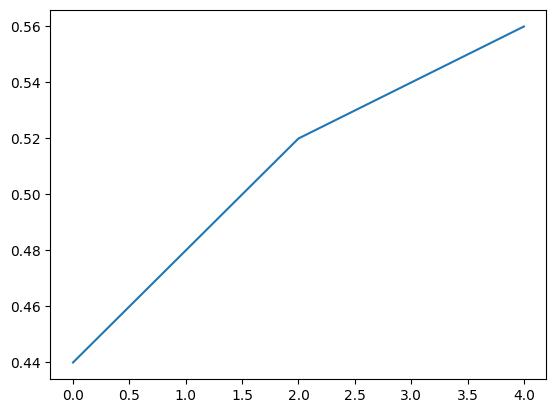

In [13]:
z += 1
plt.plot(y[z, :])

In [14]:
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)
X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), test_size=0.05, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2425, 8, 7), (2425, 5), (128, 8, 7), (128, 5))

In [15]:
model = Sequential()
model.add(Input(shape=X_train.shape[1:]))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(next_candles_count))
model.add(Reshape(y_train.shape[1:]))
model.compile(optimizer='adam', loss='mse')

In [16]:
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_split=0.2)

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2680 - val_loss: 0.0604
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1484 - val_loss: 0.0689
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1087 - val_loss: 0.0308
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1580 - val_loss: 0.0268
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0702 - val_loss: 0.0237
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0923 - val_loss: 0.0243
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0620 - val_loss: 0.0209
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0724 - val_loss: 0.0230
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0346 - val_loss: 0.0254
Epoch 10/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0500 - val_loss: 0.0205
Epoch 11/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0652 - val_loss: 0.0226
Epoch 12/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

In [17]:
X.shape, y.shape

(TensorShape([2553, 8, 7]), TensorShape([2553, 5]))

In [18]:
y_pred = model.predict(X_test)
y_pred

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


array([[ 4.02097926e-02,  1.12752438e-01,  1.90460399e-01,
         2.57609427e-01,  2.92966694e-01],
       [ 2.55308747e-01,  3.23235929e-01,  4.06927168e-01,
         4.89232063e-01,  5.40181637e-01],
       [ 5.15682101e-01,  6.36861086e-01,  7.48246908e-01,
         8.33294928e-01,  9.01611328e-01],
       [ 1.18977416e+00,  1.47774780e+00,  1.73098207e+00,
         1.91844416e+00,  2.14182758e+00],
       [ 6.89845085e-01,  8.84547949e-01,  1.10610366e+00,
         1.29480970e+00,  1.45428264e+00],
       [-5.36410064e-02, -1.18787587e-03,  4.08026874e-02,
         7.88207650e-02,  1.06872857e-01],
       [ 1.08802877e-01,  1.61922604e-01,  2.19465345e-01,
         2.69958764e-01,  3.02632093e-01],
       [ 1.61424413e-01,  1.97744846e-01,  2.35708311e-01,
         2.71935642e-01,  3.13659668e-01],
       [-2.88484514e-01, -2.46688873e-01, -1.96440518e-01,
        -1.38098449e-01, -8.08331072e-02],
       [ 2.01023892e-01,  2.67377943e-01,  3.38156193e-01,
         4.03077811e-01

In [19]:
# for y_p, y_t in zip(y_pred, y_test):
#     print("\n", (y_t[0]-y_p[0]), "\t", (y_t[1]-y_p[1]), "\t", (y_t[2]-y_p[2]))


 -0.010211013 	 -0.0127539635 	 -0.010460094

 -0.025297761 	 -0.053231657 	 -0.06691557

 0.004322171 	 0.04313922 	 0.051756144

 -0.03978026 	 -0.21775329 	 -0.36098695

 0.00015735626 	 -0.18453574 	 -0.35610366

 0.033636734 	 0.031186655 	 0.059195787

 -0.038795553 	 -0.0619165 	 -0.09945497

 -0.011422887 	 0.03225851 	 0.06429474

 0.01848787 	 0.026687652 	 0.016440213

 -0.04102786 	 -0.027380079 	 -0.028158635

 -0.08427954 	 -0.2153179 	 -0.38655496

 0.013285935 	 0.0023278445 	 -0.016407311

 -0.03468454 	 -0.06530827 	 -0.11085987

 0.0103085935 	 -0.0034117699 	 -0.041454345

 0.032229513 	 0.053760648 	 0.035932988

 -0.0048086047 	 -0.0010137558 	 0.007494509

 -0.040435866 	 -0.04042287 	 -0.05128792

 0.289367 	 0.35578555 	 0.32463473

 0.017193705 	 0.0038484037 	 -0.016631663

 0.0056886673 	 0.022919178 	 0.11207792

 0.10391769 	 0.1178149 	 0.04228401

 0.026604176 	 -0.017452002 	 0.27990985

 0.027575612 	 0.07306868 	 0.1619361

 0.15142918 	 0.16045296 	

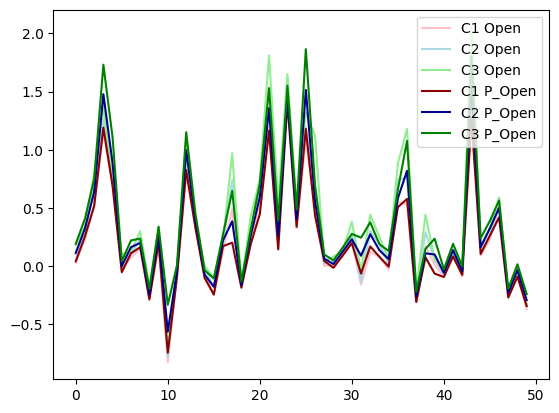

In [20]:
# Example for the first feature (e.g., Close price)
plt.plot(y_test[:50, 0], label='C1 Open', color="pink")
plt.plot(y_test[:50, 1], label='C2 Open', color="lightblue")
plt.plot(y_test[:50, 2], label='C3 Open', color="lightgreen")
plt.plot(y_pred[:50, 0], label='C1 P_Open', color="darkred")
plt.plot(y_pred[:50, 1], label='C2 P_Open', color="darkblue")
plt.plot(y_pred[:50, 2], label='C3 P_Open', color="green")
plt.legend()
plt.show()

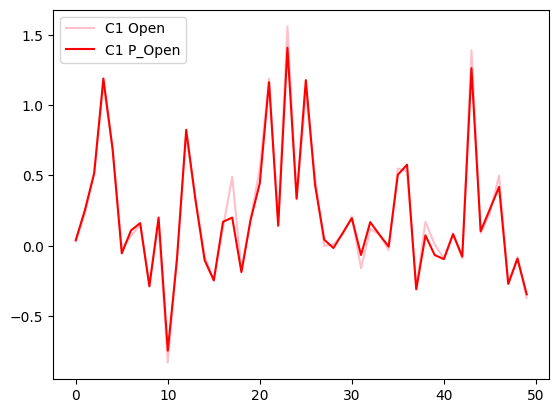

In [21]:
plt.plot(y_test[:50, 0], label='C1 Open', color="pink")
# plt.plot(y[0:5, 1], label='C2 Open', color="blue")
# plt.plot(y[0:5, 2], label='C3 Open', color="green")
plt.plot(y_pred[:50, 0], label='C1 P_Open', color="red")
# plt.plot(y_pred[0:5, 1], label='C2 P_Open', color="darkblue")
# plt.plot(y_pred[0:5, 2], label='C3 P_Open', color="darkgreen")
plt.legend()
plt.show()

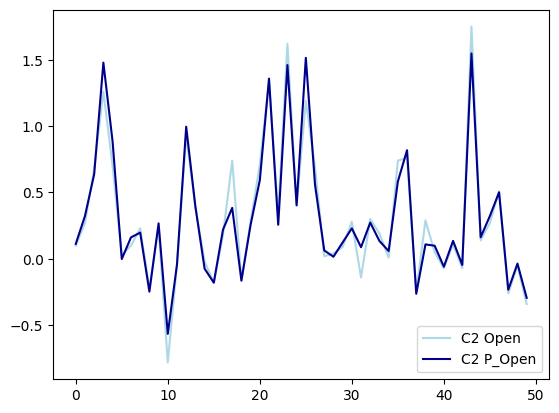

In [22]:
plt.plot(y_test[:50, 1], label='C2 Open', color="lightblue")
# plt.plot(y[0:5, 2], label='C3 Open', color="green")
# plt.plot(y_pred[0:5, 0], label='C1 P_Open', color="darkred")
plt.plot(y_pred[:50, 1], label='C2 P_Open', color="darkblue")
# plt.plot(y_pred[0:5, 2], label='C3 P_Open', color="darkgreen")
plt.legend()
plt.show()

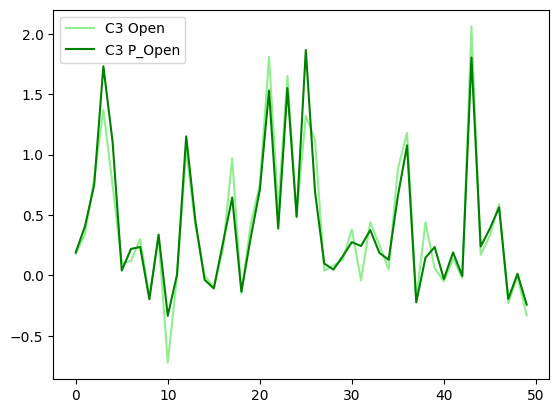

In [23]:
plt.plot(y_test[:50, 2], label='C3 Open', color="lightgreen")
# plt.plot(y_pred[0:5, 0], label='C1 P_Open', color="darkred")
# plt.plot(y_pred[0:5, 1], label='C2 P_Open', color="darkblue")
plt.plot(y_pred[:50, 2], label='C3 P_Open', color="green")
plt.legend()
plt.show()